### Building chatbot with Multiple Tools Using Langgraph

#### Aim

Create a chatbot with tool capabilities from arxiv,wikipedia search and some functions

In [25]:
from langchain_community.tools import ArxivQueryRun,WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper,ArxivAPIWrapper


In [26]:
api_wrapper_arxiv= ArxivAPIWrapper(top_k_results=2,doc_content_chars_max=500)
arxiv=ArxivQueryRun(api_wrapper=api_wrapper_arxiv)
print(arxiv.name)

arxiv


In [27]:
arxiv.invoke("Attention is all you need")

'Published: 2021-05-06\nTitle: Do You Even Need Attention? A Stack of Feed-Forward Layers Does Surprisingly Well on ImageNet\nAuthors: Luke Melas-Kyriazi\nSummary: The strong performance of vision transformers on image classification and other vision tasks is often attributed to the design of their multi-head attention layers. However, the extent to which attention is responsible for this strong performance remains unclear. In this short report, we ask: is the attention layer even necessary? Specifi'

In [28]:
api_wrapper_wiki=WikipediaAPIWrapper(top_k_results=2,doc_content_chars_max=500)
wiki=WikipediaQueryRun(api_wrapper=api_wrapper_wiki)
wiki.name


'wikipedia'

In [29]:
wiki.invoke("What is machine learning?")

'Page: Machine learning\nSummary: Machine learning (ML) is a field of study in artificial intelligence concerned with the development and study of statistical algorithms that can learn from data and generalize to unseen data, and thus perform tasks without explicit instructions. Within a subdiscipline in machine learning, advances in the field of deep learning have allowed neural networks, a class of statistical algorithms, to surpass many previous machine learning approaches in performance.\nML fi'

In [30]:
from dotenv import load_dotenv
load_dotenv()

import os
os.environ["TAVILY_API_KEY"]=os.getenv("TAVILY_API_KEY")
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")


In [31]:
### TAVILY Search Tool
from langchain_tavily.tavily_search import TavilySearch
tavily=TavilySearch()

In [32]:
tavily.invoke("Provide me the recent AI news for feb 16th of 2026")

{'query': 'Provide me the recent AI news for feb 16th of 2026',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'url': 'https://www.youtube.com/watch?v=GsHA0eAcmaI',
   'title': 'Have you heard these exciting AI news? - YouTube',
   'content': 'Have you heard these exciting AI news? - February 16, 2026 AI Updates Weekly ... Make Claude Code Better Every Time You Use It 31:50',
   'score': 0.9998894,
   'raw_content': None},
  {'url': 'https://compliancepodcastnetwork.net/ai-today-in-5-february-16-2026-the-doom-loop-edition/',
   'title': 'AI Today in 5: February 16, 2026 the Doom Loop Edition',
   'content': 'AI Today in 5: February 16, 2026 the Doom Loop Edition · Staying ahead of AI regs in housing. (HousingWire) · UN sets up panel on AI impact. (',
   'score': 0.9995592,
   'raw_content': None},
  {'url': 'https://www.reddit.com/r/ArtificialInteligence/comments/1r60g7v/oneminute_daily_ai_news_2152026/',
   'title': 'One-Minute Daily AI News 2/15/2026 : r/

In [33]:
### Combine all the tools in the list

tools=[arxiv,wiki,tavily] 

In [34]:
## Initialise my LLM Model 

from langchain_groq import ChatGroq

llm=ChatGroq(model="llama-3.1-8b-instant")

llm_with_tools=llm.bind_tools(tools)

In [35]:
from pprint import pprint
from langchain_core.messages import HumanMessage,AIMessage

llm_with_tools.invoke([HumanMessage(content=f"What is the recent AI News")]).tool_calls

[{'name': 'tavily_search',
  'args': {'date_range': 'month', 'query': 'Recent AI news', 'topic': 'news'},
  'id': '200xphh87',
  'type': 'tool_call'}]

In [36]:
## State Schema
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage
from typing import Annotated
from langgraph.graph.message import add_messages
class State(TypedDict):
    messages:Annotated[list[AnyMessage],add_messages] 

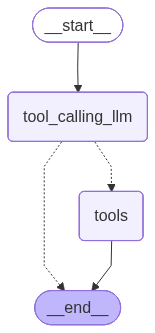

In [37]:
### Entire Chatbot With LangGraph
from IPython.display import Image, display
from langgraph.graph import StateGraph, START , END 
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

### Node defination
def tool_calling_llm(state: State):
    return {"messages":[llm_with_tools.invoke(state["messages"])]}

# Build graph
builder=StateGraph(State)
builder.add_node("tool_calling_llm",tool_calling_llm)
builder.add_node("tools",ToolNode(tools))

builder.add_edge(START,"tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    tools_condition,
)

builder.add_edge("tools",END)

graph=builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))



In [38]:
messages=graph.invoke({"messages":HumanMessage(content="What is attention is all you need?")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

What is attention is all you need?
================================== Ai Message ==================================
Tool Calls:
  arxiv (82yvqgaqf)
 Call ID: 82yvqgaqf
  Args:
    query: Attention is all you need
================================= Tool Message =================================
Name: arxiv

Published: 2021-05-06
Title: Do You Even Need Attention? A Stack of Feed-Forward Layers Does Surprisingly Well on ImageNet
Authors: Luke Melas-Kyriazi
Summary: The strong performance of vision transformers on image classification and other vision tasks is often attributed to the design of their multi-head attention layers. However, the extent to which attention is responsible for this strong performance remains unclear. In this short report, we ask: is the attention layer even necessary? Specifi


In [39]:
messages=graph.invoke({"messages":HumanMessage(content="1706.03762")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

1706.03762
================================== Ai Message ==================================
Tool Calls:
  arxiv (q22rkmz3d)
 Call ID: q22rkmz3d
  Args:
    query: 1706.03762
================================= Tool Message =================================
Name: arxiv

Published: 2023-08-02
Title: Attention Is All You Need
Authors: Ashish Vaswani, Noam Shazeer, Niki Parmar, Jakob Uszkoreit, Llion Jones, Aidan N. Gomez, Lukasz Kaiser, Illia Polosukhin
Summary: The dominant sequence transduction models are based on complex recurrent or convolutional neural networks in an encoder-decoder configuration. The best performing models also connect the encoder and decoder through an attention mechanism. We propose a new simple network architecture, the Transformer, base


In [42]:
messages=graph.invoke({"messages":HumanMessage(content="what is machine learning?")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

what is machine learning?
================================== Ai Message ==================================
Tool Calls:
  wikipedia (gywv0p8bt)
 Call ID: gywv0p8bt
  Args:
    query: Machine learning
================================= Tool Message =================================
Name: wikipedia

Page: Machine learning
Summary: Machine learning (ML) is a field of study in artificial intelligence concerned with the development and study of statistical algorithms that can learn from data and generalize to unseen data, and thus perform tasks without explicit instructions. Within a subdiscipline in machine learning, advances in the field of deep learning have allowed neural networks, a class of statistical algorithms, to surpass many previous machine learning approaches in performance.
ML fi
